In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import PIL.ImageOps    

### Boilerpalte

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# # First, look at everything.
# from subprocess import check_output
# print(check_output(["ls", "./data/combined_dataset/combined"]).decode("utf8"))

In [4]:
class Config():
    training_dir = "./data/combined_dataset/combined"
    testing_dir = "./data/combined_dataset/combined"
    training_csv="./data/combined_dataset/train_triplet_data.csv"
    testing_csv="./data/combined_dataset/test_triplet_data.csv"
    
    # train_batch_size = 12
    train_batch_size = 32
    train_number_epochs = 5

In [5]:
training_dir = "./data/combined_dataset/combined"
testing_dir = "./data/combined_dataset/combined"
training_csv="./data/combined_dataset/train_triplet_data.csv"
testing_csv="./data/combined_dataset/test_triplet_data.csv"

In [6]:
# RESCALE_SIZE = 225
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [7]:
pd.read_csv(training_csv)

,anchor,positive,negative
0,00001/NFI-00101001.png,00001/NFI-00102001.png,00001_forg/NFI-00301001.png
1,00001/NFI-00101001.png,00001/NFI-00102001.png,00001_forg/NFI-00302001.png
2,00001/NFI-00101001.png,00001/NFI-00102001.png,00001_forg/NFI-00303001.png
3,00001/NFI-00101001.png,00001/NFI-00102001.png,00001_forg/NFI-00304001.png
4,00001/NFI-00101001.png,00001/NFI-00102001.png,00001_forg/NFI-00305001.png
...,...,...,...
691127,1111123/9.png,1111123/8.png,1111123_forg/5.png
691128,1111123/9.png,1111123/8.png,1111123_forg/6.png
691129,1111123/9.png,1111123/8.png,1111123_forg/7.png
691130,1111123/9.png,1111123/8.png,1111123_forg/8.png


In [8]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns = ['anchor', 'positive', 'negative']
        self.training_dir = training_dir    
        self.transform = transform


    def __getitem__(self,index):
        

        # getting the image path
        anchor_path = os.path.join(self.training_dir, self.training_df.iat[index,0])
        positive_path = os.path.join(self.training_dir, self.training_df.iat[index,1])
        negative_path = os.path.join(self.training_dir, self.training_df.iat[index,2])

        # Loading the image
        anchor = Image.open(anchor_path).convert('L')
        positive = Image.open(positive_path).convert('L')
        negative = Image.open(negative_path).convert('L')

        anchor = ImageEnhance.Contrast(anchor).enhance(1.5)
        positive = ImageEnhance.Contrast(positive).enhance(1.5)
        negative = ImageEnhance.Contrast(negative).enhance(1.5)

        anchor = ImageEnhance.Brightness(anchor).enhance(1.5)
        positive = ImageEnhance.Brightness(positive).enhance(1.5)
        negative = ImageEnhance.Brightness(negative).enhance(1.5)

        anchor = PIL.ImageOps.invert(anchor)
        positive = PIL.ImageOps.invert(positive)
        negative = PIL.ImageOps.invert(negative)


        # img0 = 255 - img0
        # img1 = 255 - img1

        anchor = anchor.convert('RGB')
        positive = positive.convert('RGB')
        negative = negative.convert('RGB')
        

        # print(image1_path, image2_path)
        anchor.load()
        positive.load()
        negative.load()

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            
        return anchor, positive , negative
    
    def __len__(self):
        return len(self.training_df)

In [9]:
transform = transforms.Compose([
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
      

              # transforms.RandomRotation(degrees = 10, fill=255),
            #   transforms.RandomRotation(degrees = 20),
              transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.RandomRotation(degrees = 15, fill=0),
            transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(0,0,0)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.95, 1.05)),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.9, 1.4)),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [10]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)

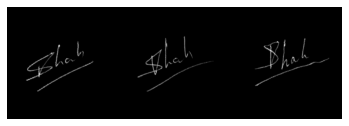

In [25]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

### ResNet Siamese

In [26]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        # self.resnet = models.resnet50(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                # nn.Linear(num_ftrs, 512),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # nn.Linear(512, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # # nn.Linear(128,16)
                # nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3


In [27]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

    # for param in model.layer3.parameters():
    #   param.requires_grad = True
    
    # for param in model.layer4.parameters():
    #   param.requires_grad = True

    # for param in model.avgpool.parameters():
    #   param.requires_grad = True

    # for param in model.fc.parameters():
    #   param.requires_grad = True

In [28]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
        
#         self.resnet = models.inception_v3(pretrained=False)
#         set_parameter_requires_grad(self.resnet)
#         # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
#         # self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
#         num_ftrs = self.resnet.fc.in_features
#         self.resnet.fc = nn.Sequential(
#                 nn.Linear(num_ftrs, 16),
#                 # nn.Linear(num_ftrs, 512),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # nn.Linear(512, 128),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # # nn.Linear(128,16)
#                 # nn.Linear(128,2)
#             )
        
#     def forward_once(self, x):
#         output = self.resnet(x)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2


In [29]:
# def set_parameter_requires_grad(model):
#     for param in model.parameters():
#         param.requires_grad = True

#     # for param in model.layer3.parameters():
#     #   param.requires_grad = True
    
#     # for param in model.layer4.parameters():
#     #   param.requires_grad = True

#     # for param in model.avgpool.parameters():
#     #   param.requires_grad = True

#     # for param in model.fc.parameters():
#     #   param.requires_grad = True

In [36]:
net = SiameseNetwork().cuda()
train_dataset = SiameseNetworkDataset(training_csv=Config.training_csv, training_dir=Config.training_dir, transform=transform)

In [37]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### Loss

In [38]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

### Train

In [39]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [40]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for i, data in enumerate(train_loader,0):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1, img2)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()

        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
              
    train_loss = running_loss / processed_data

    return train_loss

In [41]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.AdamW(net.parameters(), lr=0.05)
        scheduler = StepLR(opt, step_size=4, gamma=0.5)
        criterion = TripletLoss()

        for epoch in range(epochs):
            train_loss = fit_epoch(net, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            scheduler.step()
            history.append((train_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))
            
    return history

In [42]:
history = train(train_dataset, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)

epoch:   0%|          | 0/5 [3:21:28<?, ?it/s]


KeyboardInterrupt: 

In [25]:
torch.save(net.state_dict(), "model_triplet.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [ ]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [34]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 10),
            #   transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [35]:
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,                                     transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [28]:
from tqdm import tqdm

In [ ]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([1.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1 , label = data
    output1,output2 = net(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        targets.append(0)
    else:
        targets.append(1)
    
    if eucledian_distance <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

In [ ]:
f1_score(n_targets, n_predictions, average='weighted')

In [ ]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

In [ ]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

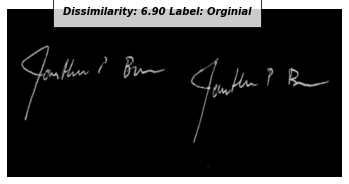

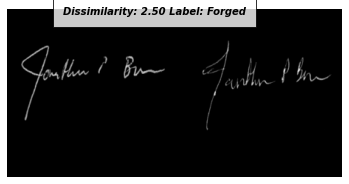

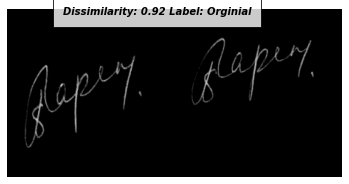

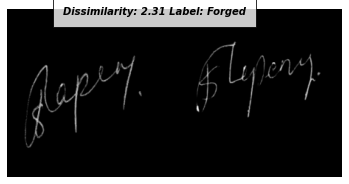

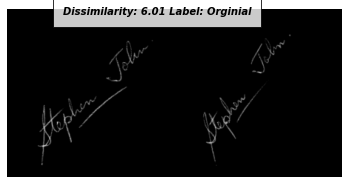

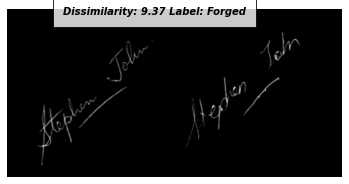

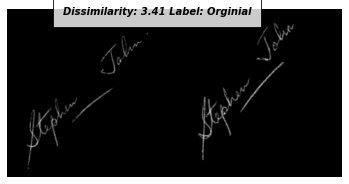

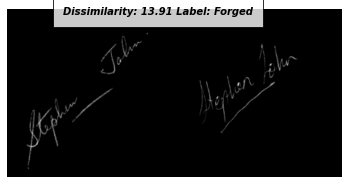

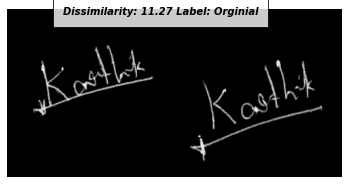

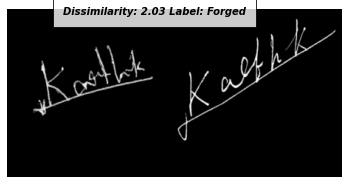

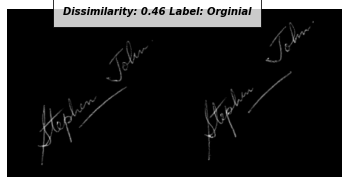

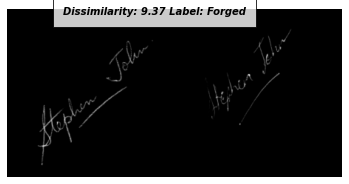

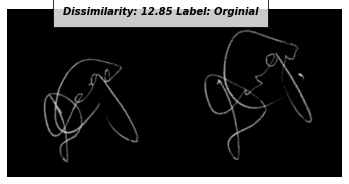

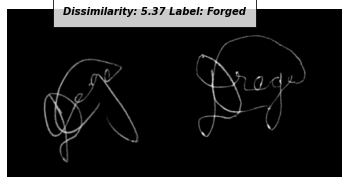

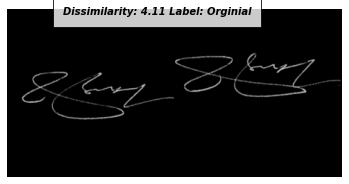

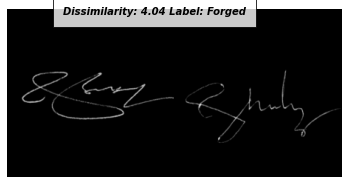

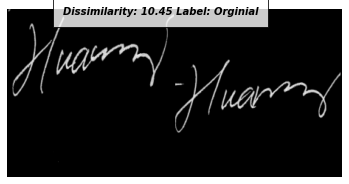

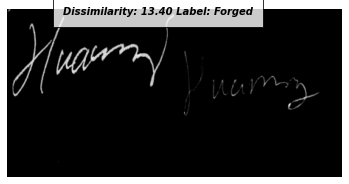

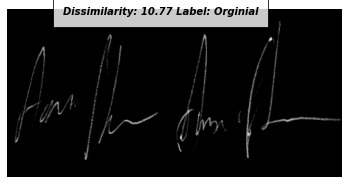

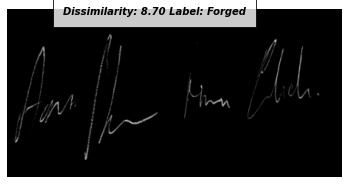

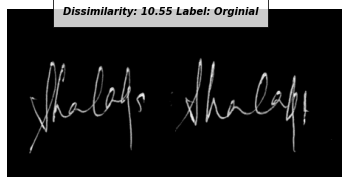

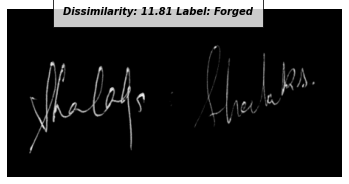

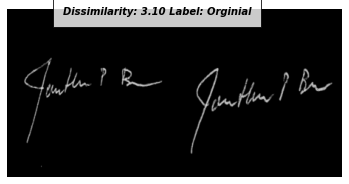

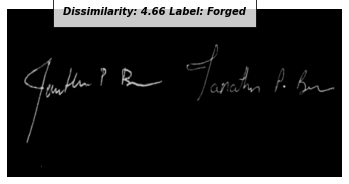

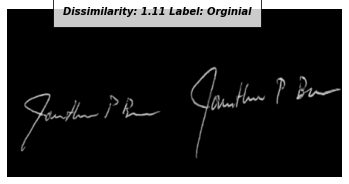

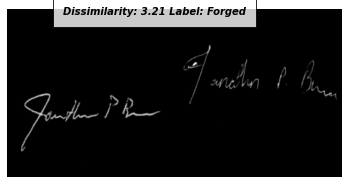

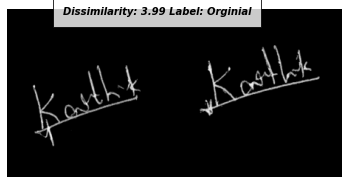

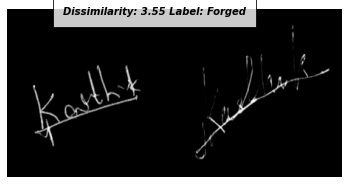

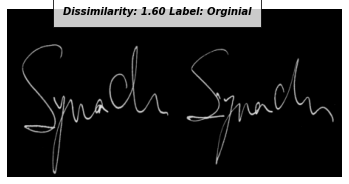

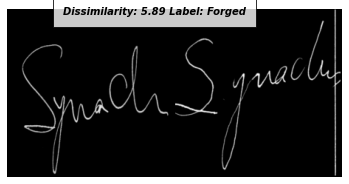

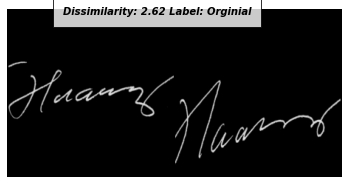

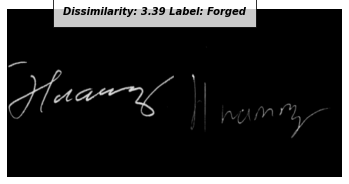

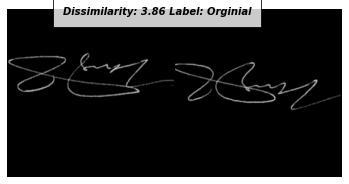

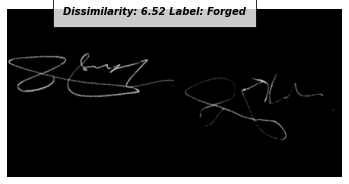

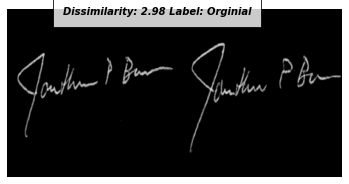

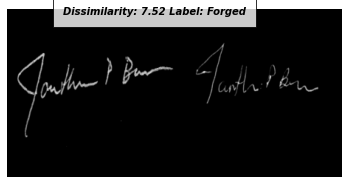

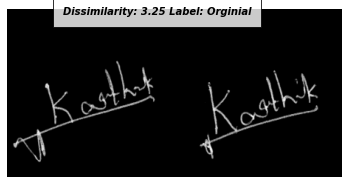

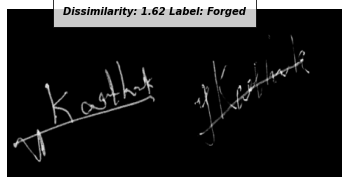

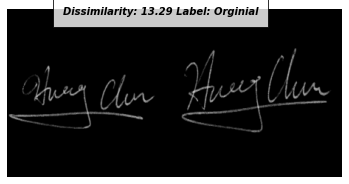

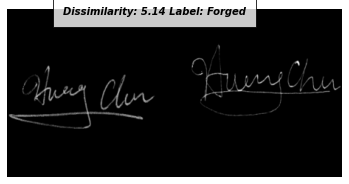

In [37]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Public kernel: https://www.kaggle.com/robinreni/signature-classification-using-siamese-pytorch 